# Isolation Forest

In [ ]:
https://www.youtube.com/watch?v=TOK7Kq7x0yc&t=202s&ab_channel=Karpov.Courses

Этот алгоритм использует идеи случайного леса для присвоения точкам "скора" нормальности. Представим дерево, которое на каждом шаге выбирает случайный признак и случайное значение этого признака (из интервала от минимума до максимума выбранного признака), а остальную выборку делит пополам - та часть, у которой значения признака больше, и та, у которой меньше. Так дерево можно строить рекурсивно до какой-то наперед заданной глубины или пока все не переберется. Такое дерево называется "Изоляционным" деревом или iTree. А теперь магия: если выброс - точка, которая "выпадает" из общего распределения, то она в таком дереве будет находиться выше, чем средняя "нормальная" точка. 

Иллюстрация:

<img src="https://miro.medium.com/max/1400/1*ujfv7WJH-tL1cRLxYEoicg.png">

Наше дерево как будто бы набрасывает прямые, параллельные координатным осям (нашим признакам) в пространство и тем самым делит его на сегменты. Теперь можно построить лес из таких деревьев. Тогда для каждого дерева нужно взять не весь набор точек, а его подмножество фиксированного размера. Осталось только разобраться, как измерить, что считается аномальным, а что нормальным. 

### Формула:

$$score = e^{-\dfrac{E(h(n))}{c(n)}}$$

$E(h(n))$ - усредненная по всем деревьям длина пути до точки 

$с(n)$ - средняя длина пути до точки (в бинарных деревьях поиска эта штука известна как "средняя длина неудачного поиска")

$c(n) = 2H_{n-1}-\dfrac{2(n-1)}{n}$

$H_{n-1}$ - гармоническое число


Если скор близок к 0, то точка аномальная, если близок к 1, то нормальная. Отсечку часто ставят на значении 0.5.

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Обучение
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Нормальные наблюдения
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Выбросы
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

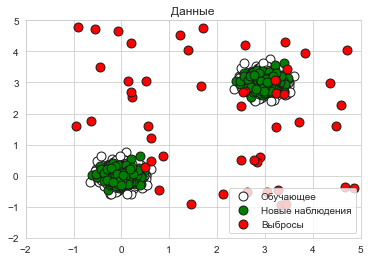

In [357]:
# Рисовалка
plt.title("Данные")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Новые наблюдения", "Выбросы"],
           loc="lower right")

plt.show()

In [358]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng)
clf.fit(X_train)

# Предсказания
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

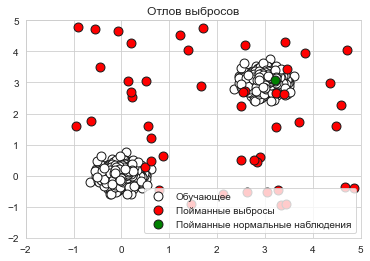

In [359]:
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Отлов выбросов")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Пойманные выбросы", 
            "Пойманные нормальные наблюдения"],
           loc="lower right")


plt.show()

[Читать](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) про IsolationForest в sklearn

# Extended Isolation Forest

Конечно, любой метод можно попытаться "докрутить", IsolationForest доработали [тут](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

**Зачем**

Если ваш набор точек имеет некоторую сложную структуру, обработать ее с помощью линий, параллельных осям координат может оказаться непросто даже для двумерного случая. Примеры разброса точек:

<img src="https://github.com/sahandha/eif/raw/master/figures/Training.png">

Тепловая карта скора, полученного стандартным IsolationForest:

<img src="https://github.com/sahandha/eif/raw/master/figures/scores_maps.png">

Видно, что многое перемешалось.

Давайте вместо линий(гиперплоскостей), параллельных осям будем набрасывать просто случайные гиперплоскости(без условия параллельности осям).

Тогда наши разбиения плоскостями примут вид:
<img src="https://github.com/sahandha/eif/raw/master/figures/Ex1.png">

In [133]:
!pip install eif

     |████████████████████████████████| 1.6 MB 1.6 MB/s eta 0:00:01
  Created wheel for eif: filename=eif-2.0.2-cp38-cp38-macosx_10_9_x86_64.whl size=52851 sha256=9b58f5236f85cb2d00893a78c090a9fb6bb08cdd6d3565c72c825543d061fa49
  Stored in directory: /Users/i.pile/Library/Caches/pip/wheels/09/03/7b/a12d773555eff50431637ce26cbcc2b1b9c582c8b09b2d8350
Successfully built eif


In [360]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

Сделаем два кластера точек

In [361]:
mean1 = [10, 0]
cov1 = [[1, 0], [0, 1]]  

mean2 = [0, 10]
cov2 = [[1, 0], [0, 1]]

Nobjs = 500          # Сколько точек брать
np.random.seed(1)    

x1, y1 = np.random.multivariate_normal(mean1, cov1, int(Nobjs/2)).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, int(Nobjs/2)).T

# Собираем в один датасет
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
X=np.array([x,y]).T

Картиночка

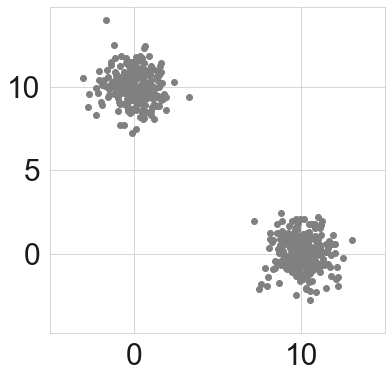

In [362]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])
plt.grid("off")
plt.axis("equal")

plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=30)

plt.show()

Сравним результаты от обычного леса и "улучшенного"

In [363]:
F0  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=1)

In [364]:
# Скорим обучающую выборку
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

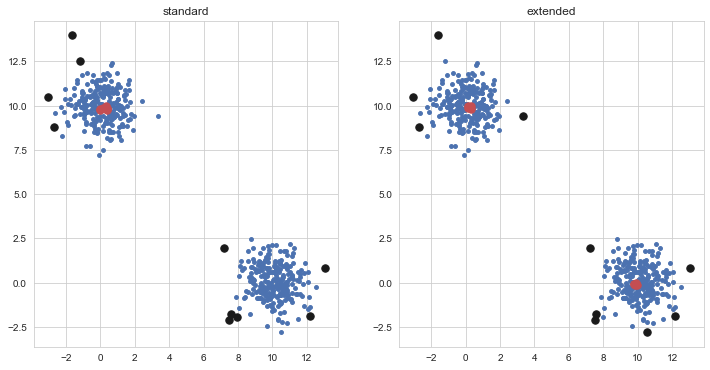

In [365]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

Давайте теперь нарисуем тепловую карту скоров. 

In [367]:
xx, yy = np.meshgrid(np.linspace(-5, 15, 30), np.linspace(-5, 15, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

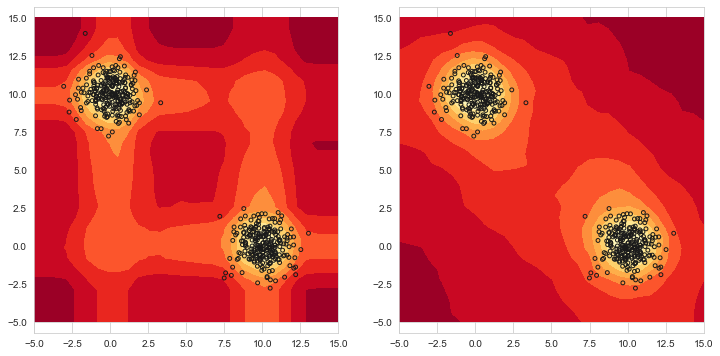

In [368]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


plt.show()

А как еще бывает?

Например есть библиотека PyOD. Примеры [здесь](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

[Одноклассовый SVM](https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c)